# Setup
Make sure to run `docker-compose up` to run QDrant database

In [22]:
# Running in background. Port 6333
! docker-compose up -d qdrant

 Network painting_recognition_default  Creating
 Network painting_recognition_default  Created
 Container painting_recognition-web-1  Creating
 Container painting_recognition-web-1  Created
 Container painting_recognition-web-1  Starting
 Container painting_recognition-web-1  Started


Open [lolalhost](http://127.0.0.1:6333/dashboard) to see QDrant dashboard

# Imports

In [23]:
# Utils
import os
import random
random.seed(42)

# Image processing
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, Batch
from qdrant_client.http.exceptions import UnexpectedResponse
from transformers import ViTImageProcessor, ViTModel
import torch

# Data processing
from datasets import load_dataset
import numpy as np

# Constants

In [24]:
qdrant = '127.0.0.1'
port = 6333
collection_name = 'images'
vectore_size = 384
distance = Distance.COSINE

data_folder = os.path.join('..', 'data', 'operas')

# Create QDrant store

In [26]:
client = QdrantClient(qdrant, port=port) # QDrant client -> localhost
try:
    [client.create_collection(
        collection_name=c,
        vectors_config=VectorParams(size=vectore_size, distance=distance)
    ) for c in [collection_name]]
except UnexpectedResponse as e:
    print('Collection already exists')

# Dataset creation
Simply load datasets from `data` folder using HF datasets library

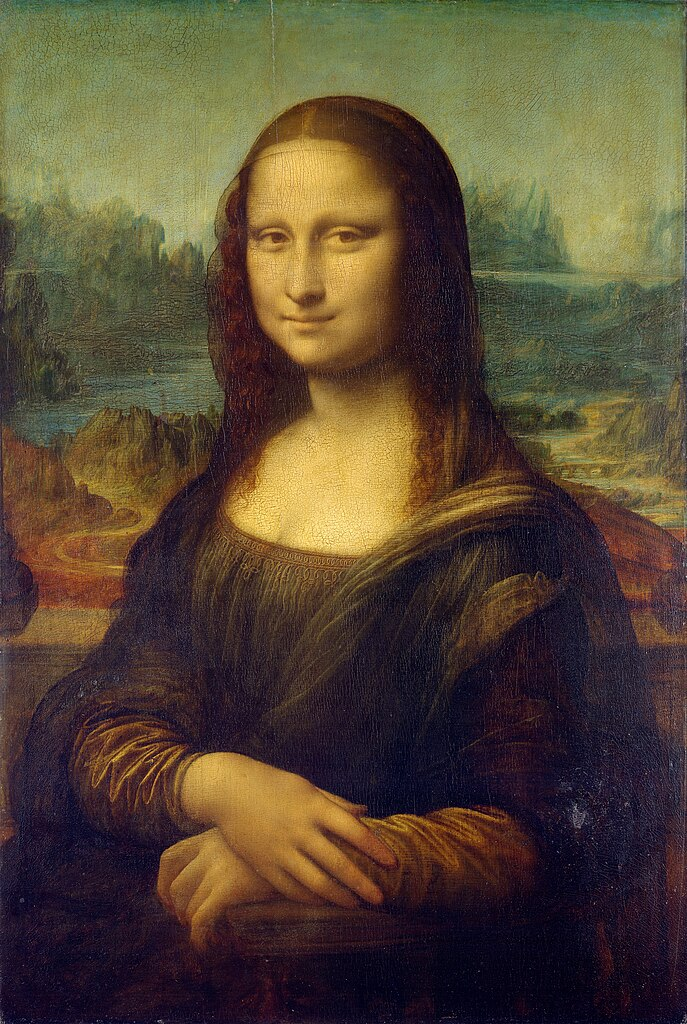

In [27]:
data = load_dataset("imagefolder", data_dir=data_folder)['train']

# sculptures[0]['image']
data[1]['image']

# Testing around
First we need to create the processor and the model.
We are going to use free Facebook's dino-vist16 model for processor and model both

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16', device=device)
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Run example
Run the processor on a given image (mona lisa) and see the results

The processor returns a list of tensors representing the RPG image
- 1 image
- 3 channels
- 224x224 size

We need to run the model on the image to get the embeddings

In [29]:
mona_lisa = data[1]['image']
inputs = processor(images=mona_lisa, return_tensors="pt").to(device)
print(inputs['pixel_values'].shape)
one_embedding = model(**inputs).last_hidden_state
print(one_embedding.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 197, 384])


The model return it's representation of the image as a multi-dimensional vector

now we need to get the embeddings from the model using a function (mean in this case). This will calculate the mean on the given azis giving us a mono-dimensional vector of the image (the embedding itself)

In [30]:
one_embedding.mean(dim=1).shape

torch.Size([1, 384])

## Apply to the dataset

Now let's apply the same process to the whole dataset

In [31]:
def get_embedding(batch_images):
    inputs = processor(images=batch_images['image'], return_tensors="pt").to(device)
    with torch.no_grad():
        out = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    batch_images['embeddings'] = out
    return batch_images

In [32]:
dataset = data.map(get_embedding, batched=False)
dataset

Map: 100%|██████████| 5/5 [00:00<00:00,  8.86 examples/s]


Dataset({
    features: ['image', 'embeddings'],
    num_rows: 5
})

Now let's save the embeddings to the QDrant store

In [33]:
image_embeddings = np.array(dataset['embeddings'])
image_embeddings = image_embeddings.reshape(image_embeddings.shape[0], -1).tolist()
ids = list(range(1, len(image_embeddings) + 1))
names = [n.split('.')[0] for n in os.listdir(data_folder)]

payloads = [{'name': p} for p in names]

client.upsert(
    collection_name=collection_name,
    points=Batch(
        ids=ids,
        vectors=image_embeddings,
        payloads=payloads
    )
)


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [34]:
# Count elements in collection
client.count(collection_name=collection_name, exact=True)

CountResult(count=5)

In [35]:
# Get payload and vector in collection
client.scroll(collection_name=collection_name, with_vectors=True)

([Record(id=1, payload={'name': 'david'}, vector=[0.011395845, -0.0050629387, -0.05215735, 0.0103605455, 0.09320436, 0.050982058, 0.07024988, -0.03688545, -0.0037267264, 0.030698556, -0.017396145, -0.046443336, 0.05845689, -0.07464513, 0.099999465, -0.0319641, 0.023452148, -0.00044032984, -0.030534988, -0.028043272, 0.009660323, 0.029818233, -0.001236003, 0.02956861, -0.046199583, 0.04806776, 0.023762885, -0.06141859, -0.025567317, 0.016812809, 0.05477815, -0.032475524, 0.02958584, -0.007966693, -0.019999353, 0.094254285, -0.039847, 0.016255718, -0.03132694, -0.001172112, 0.06915602, 0.006012879, -0.014700627, -0.066874556, -0.07233781, -0.079809465, 0.014577912, -0.020674493, 0.051153634, 0.0032158904, -0.1013044, -0.012191348, 0.02282694, 0.00055592577, 0.052391704, -0.032544795, -0.028312132, -0.06543074, -0.013246085, -0.011680934, -0.007080257, 0.15723608, 0.024542982, 0.0018281487, 0.012713763, 0.07737045, -0.0013338774, 0.026921995, 0.06284136, -0.07672564, -0.020561168, 0.06902

# Semantic search
Now let's try to find the most similar images to the given one using `one_embedding` mona lisa

In [36]:
client.search(
    collection_name=collection_name,
    query_vector=one_embedding.mean(dim=1).cpu().detach().numpy()[0],
    score_threshold=0.9,
    limit = 10
)

[ScoredPoint(id=2, version=0, score=1.0, payload={'name': 'mona_lisa'}, vector=None, shard_key=None)]

## Modify the image and check the results
Let's try to modify the image by appling transformations (rotation, traslation, ...) it and see how the results change

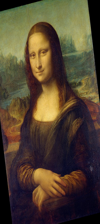

In [43]:
transformed = mona_lisa.rotate(10, expand=False)
transformed = transformed.resize((100, 224))
transformed

In [44]:
transformed_embedding = processor(images=transformed, return_tensors="pt").to(device)
transformed_embedding = model(**transformed_embedding).last_hidden_state.mean(dim=1).cpu().detach().numpy()[0]
client.search(
    collection_name=collection_name,
    query_vector=transformed_embedding,
    limit = 1
)

[ScoredPoint(id=2, version=0, score=0.9122187, payload={'name': 'mona_lisa'}, vector=None, shard_key=None)]

## Check other images

In [17]:
for name, img in zip(names, image_embeddings):
    res = client.search(
        collection_name=collection_name,
        query_vector=img,
        limit = 1
    )[0]
    print(f'Searching for {name}, found:', res.payload['name'])

Searching for david, found: david
Searching for mona_lisa, found: mona_lisa
Searching for scream, found: scream
Searching for starry_night, found: starry_night
Searching for the_thinker, found: the_thinker


## Let's modify the images
same experiment done with mona lisa but with other images

In [18]:
search_result = 0
for name, data_image in zip(names, data):    
    img = data_image['image']
    transformed = transformed.resize((random.randint(800, 2000), random.randint(800, 2000)))
    transformed = img.rotate(random.randint(-90, 90), expand=False)
    transformed_embedding = processor(images=transformed, return_tensors="pt").to(device)
    transformed_embedding = model(**transformed_embedding).last_hidden_state.mean(dim=1).cpu().detach().numpy()[0]
    res = client.search(
        collection_name=collection_name,
        query_vector=transformed_embedding,
        limit = 1
    )[0]
    payload_name = res.payload['name']
    print(f'Searching for {name}, found:', payload_name)
    search_result += name == payload_name

accuracy = 100 * search_result / len(names)
print(f'\nAccuracy: {accuracy:.2f}%')

Searching for david, found: david
Searching for mona_lisa, found: mona_lisa
Searching for scream, found: scream
Searching for starry_night, found: starry_night
Searching for the_thinker, found: the_thinker

Accuracy: 100.00%


# Cleanup resources

In [45]:
! docker-compose down

 Container painting_recognition-web-1  Stopping
 Container painting_recognition-web-1  Stopped
 Container painting_recognition-web-1  Removing
 Container painting_recognition-web-1  Removed
 Network painting_recognition_default  Removing
 Network painting_recognition_default  Removed
